# CNN U-NET: Skull-Stripping em Imagens 2D

From: https://github.com/jocicmarko/ultrasound-nerve-segmentation

Exemplo de Skull-Stripping (Segmentação do cérebro) em imagens 2D de ressonância magnética utilizando a implementação da CNN U-NET do link acima. Os resultados iniciais desta implementação foram submetidos ao evento BRAINN 2017.

Neste exemplo utilizou-se as imagens do dataset CC-349, em que 250 imagens foram utilizadas para treino e como efeito ilustrativo, o teste foi realizado em 4 imagens as quais são apresentadas no fim do notebook.
         
CC-349 dataset: http://miclab.fee.unicamp.br/calgary-campinas-359 

Artigo U-NET: https://arxiv.org/pdf/1505.04597.pdf

Arquitetura da U-NET:
![](http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

**Informações das pastas**:

```
src/
    train_mid_samples/ (imagens do treino em 2D da fatia central sagital) - Já criada. 
    train_patches/ (patches para o treino) - Código irá criar!
    test_mid_samples/ (imagens do test em 2D da fatia central sagital) - Já criada.
    test_patches/ (patches para o teste) Código irá criar!
    test_prep_data/ (dados de teste pré-processados para predição) - Código irá criar! 
    pred_data/ (resultados das predições da CNN) - Código irá criar!
    pred_image/ (imagens reconstruídas a partir das predições da CNN) - Código irá criar!

```


# Módulos a serem utilizados

In [1]:
%matplotlib inline
import numpy as np
import os
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"    
import theano

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
# Keras
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K


Using Theano backend.


Biblioteca necessária para leitura de dados em ordem lexográfica.

In [3]:
!pip install natsort

In [3]:
import glob
import time
import cv2
import matplotlib.pylab as plt
import sys
sys.path.append('../src') # Funções de auxílio de pré-processamento
from prep_ss_utils import create_data, save_2d_samples
from prep_ss_utils import sample_2d_patches, preprocess, get_mean_std_train, read_prep_test
from prep_ss_utils import load_train_data, reconstruct_2d_sample, save_data
from my_keras_utilities import TrainingPlotter, load_model_and_history

[TerminalIPythonApp] WARNING | Subcommand `ipython nbconvert` is deprecated and will be removed in future versions.
[TerminalIPythonApp] WARNING | You likely want to use `jupyter nbconvert` in the future
[NbConvertApp] WARNING | pattern u'prep_ss_utils.py' matched no files
This application is used to convert notebook files (*.ipynb) to various other
formats.


Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--execute
    Execute the notebook prior to export.
--allow-errors
    Continue notebook execution even if one of the cells throws an error and include the error message in the cell output (the default behaviour is to abort conversion). This flag is only relevant if '--execute' was specified, too.
--stdout
    Write notebook output to stdout instead of files.
--stdin
    read a single notebook file from stdin. Write the resulti

In [4]:
# Diretório do notebook
out = '/root'

# Configurações da u-net - Tamanho do patch
img_rows = 64
img_cols = 80
smooth = 1.
model_name = '/opt/projects/models/epoch_30_unet' #'30_epoch_unet.hdf5'

# Pastas que estão ou serão criadas no diretório do notebook
train_mid_samples = 'train_mid_samples'
train_patches = 'train_patches'
test_mid_samples = 'test_mid_samples'
test_patches = 'test_patches'
test_prep_data = 'test_prep_data'
pred_image = 'pred_image'
pred_data = 'pred_data'

# Função para criar novo diretório
def create_new_dir(dstDir):
    
    if not os.path.exists(dstDir):
        os.makedirs(dstDir)

# Pré-processamento

## Dados de Treino

In [6]:
if __name__ == '__main__':

    start_time = time.time()
    
    # Treino   
    print('-'*30)
    print('Creating Train 2D Patches...')
    print('-'*30)
    srcDir = os.path.join(out,train_mid_samples)
    dstDir = os.path.join(out,train_patches) 
    create_new_dir(dstDir)

    sample_2d_patches(srcDir, dstDir, 'train')  # Extração dos patches da imagem de entrada
        
    print('-'*30)
    print('Creating Train Data...')
    print('-'*30)
    
    imgs, imgs_mask = create_data(dstDir)
    save_data(imgs, imgs_mask, os.path.join(out,'imgs_train.npy')  # Salvando os patches em arrays npy
              , os.path.join(out,'imgs_mask_train.npy'),out)
    
    print("--- %s seconds ---" % (time.time() - start_time))

------------------------------
Creating Train 2D Patches...
------------------------------
Sampling Train Images ...
('Saving train image patches:', 'CAMP_SLE_CONTROL0002')
('Saving train image patches:', 'CAMP_SLE_CONTROL0004')
('Saving train image patches:', 'CAMP_SLE_CONTROL0006')
('Saving train image patches:', 'CAMP_SLE_CONTROL0007')
('Saving train image patches:', 'CAMP_SLE_CONTROL0008')
('Saving train image patches:', 'CAMP_SLE_CONTROL0009')
('Saving train image patches:', 'CAMP_SLE_CONTROL0015')
('Saving train image patches:', 'CAMP_SLE_CONTROL0021')
('Saving train image patches:', 'CAMP_SLE_CONTROL0022')
('Saving train image patches:', 'CAMP_SLE_CONTROL0024')
('Saving train image patches:', 'CAMP_SLE_CONTROL0027')
('Saving train image patches:', 'CAMP_SLE_CONTROL0028')
('Saving train image patches:', 'CAMP_SLE_CONTROL0029')
('Saving train image patches:', 'CAMP_SLE_CONTROL0030')
('Saving train image patches:', 'CAMP_SLE_CONTROL0031')
('Saving train image patches:', 'CAMP_SLE_C

## Dados de Teste

In [7]:
if __name__ == '__main__':

    start_time = time.time()

    # Teste 
    print('-'*30)
    print('Creating Test 2D Patches...')
    print('-'*30)
    srcDir = os.path.join(out,test_mid_samples)
    dstDir = os.path.join(out,test_patches) 
    create_new_dir(dstDir)

    sample_2d_patches(srcDir, dstDir, 'test') # Criando patches para 4 imagens de teste

    print('-'*30)
    print('Creating Preprocessed Test Data...')
    print('-'*30)
    dstDir = os.path.join(out,'test_prep_data') 
    create_new_dir(dstDir)
    test_patches_folds = np.sort(glob.glob(os.path.join(out,test_patches +'/*')))
    mean, std = get_mean_std_train(os.path.join(out,'imgs_train.npy')         # Calcula média e desvio padrão
                                   , os.path.join(out,'imgs_mask_train.npy'))
       
    for fold in test_patches_folds:
        name = fold.split('/')[-1]
        print ("Image:", name)
        print ('\n')
        imgs, imgs_mask = create_data(fold)
        imgs_test = read_prep_test(imgs,mean,std)   # Normalização, média 0, std = 1
        np.savez_compressed(os.path.join(dstDir,name +'-prep.npz'),
                            imgs_test = imgs_test)
        
    print("--- %s seconds ---" % (time.time() - start_time))
    

------------------------------
Creating Test 2D Patches...
------------------------------
Sampling Test Images ...
('Saving test image patches:', 'CVCD10010001')
/root/test_patches/CVCD10010001
('Saving test image patches:', 'CVCD10010002')
/root/test_patches/CVCD10010002
('Saving test image patches:', 'CVCD10010003')
/root/test_patches/CVCD10010003
('Saving test image patches:', 'CVCD10010004')
/root/test_patches/CVCD10010004
------------------------------
Creating Preprocessed Test Data...
------------------------------
('Image:', 'CVCD10010001')


Done: 0/34161 images
Done: 100/34161 images
Done: 200/34161 images
Done: 300/34161 images
Done: 400/34161 images
Done: 500/34161 images
Done: 600/34161 images
Done: 700/34161 images
Done: 800/34161 images
Done: 900/34161 images
Done: 1000/34161 images
Done: 1100/34161 images
Done: 1200/34161 images
Done: 1300/34161 images
Done: 1400/34161 images
Done: 1500/34161 images
Done: 1600/34161 images
Done: 1700/34161 images
Done: 1800/34161 images

# Callback modificado

In [8]:
import os, time
import numpy as np
import cPickle as pickle
from IPython import display
import matplotlib.pyplot as plot
from keras.models import load_model
from keras.callbacks import Callback

def load_model_and_history(name):
    model_fn = name + '.model'
    history_fn = name + '.history'
    model, callback = None, None
    if os.path.isfile(model_fn):
        model = load_model(model_fn)
        if os.path.isfile(history_fn):
            callback = pickle.load(open(history_fn, 'rb'))
    return model, callback

def save_model_and_history(name, model, histo):
    model.save(name + '.model', overwrite=True)
    pickle.dump(histo, open(name + '.history', 'wb'))
    
class TrainingPlotter_2(Callback):
    """
    History + ModelCheckpoint + EarlyStopping + PlotLosses
    """
    def __init__(self, n=1, filepath=None, patience=10, axis=None):
        self.history = []
        self.best_loss = np.inf
        self.best_epoch = 0
        self.filepath = filepath
        self.patience = patience
        
        self.n = n
        self.line1 = None
        self.line2 = None
        self.axis = axis
                
    def __getstate__(self):
        # we do not want to pickle the matplotlib line1/line2/axis
        return dict(n=self.n, history=self.history, best_loss=self.best_loss, 
                    best_epoch=self.best_epoch, filepath=self.filepath, 
                    patience=self.patience, line1=None, line2=None, axis=None)

    def get_nepochs(self):
        return len(self.history)
    
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_t0 = time.time()

    def on_epoch_end(self, epoch, logs={}):
        # {'acc': 0.97, 'loss': 0.08, 'val_acc': 0.98, 'val_loss': 0.06}
        epoch += self.nepochs
        epoch_time = time.time() - self.epoch_t0
        self.history.append(logs)
        
        if 'loss' in logs.keys():
            early_stop_msg = ''
            if logs['loss'] < self.best_loss:
                self.best_loss = logs['loss']
                self.best_epoch = epoch
                self.waiting = 0
                if self.filepath is not None:
                    save_model_and_history(self.filepath, self.model, self)
            else:
                self.waiting += 1
                if self.waiting > self.patience:
                    self.model.stop_training = True
                    early_stop_msg = 'Early Stopped.'
            val = False
        else:
            val = False
            
        if self.axis is None:
            self.axis = plot

        try:
            if (len(self.history) % self.n) == 0:
                htrain = np.array([v['loss'] for v in self.history], np.float32)
                if val:
                    hvalid = np.array([v['val_loss'] for v in self.history], np.float32)

                if self.line2 is None:
                    self.line2 = self.axis.plot(htrain, linewidth=2, label='training mse')[0]
                    if val:
                        self.line1 = self.axis.plot(hvalid, linewidth=2, label='validation mse')[0]
                        self.axis.vlines(self.best_epoch, 0, 1, colors='#EBDDE2', linestyles='dashed', 
                                         label='validation min')
                else:
                    self.line2.set_xdata(np.arange(htrain.shape[0]))
                    self.line2.set_ydata(htrain)
                    if val:
                        self.line1.set_xdata(np.arange(hvalid.shape[0]))
                        self.line1.set_ydata(hvalid)
                        self.axis.vlines(self.best_epoch, 0, 1, colors='#EBDDE2', linestyles='dashed')
                    
                self.axis.legend()
                if 'dice_coef' in logs.keys():
                    acc = ' Accuracy = {:.2f}%'.format(100.0 * self.history[self.best_epoch]['dice_coef'])
                else:
                    acc = ''
                if val:
                    self.axis.title('{} Best loss is {:.5f} on epoch {:d}.{}'
                                    .format(early_stop_msg, self.best_loss, self.best_epoch, acc), 
                                    weight='bold')
                    self.axis.ylabel('Losses [{:.5f} / {:.5f}]'.format(htrain[-1], hvalid[-1]))
                else:
                    self.axis.ylabel('Training Loss: {:.5f}'.format(htrain[-1]))
                self.axis.xlabel('Epoch [{}: {:.2f}s]'.format(epoch, epoch_time))
                
                display.display(plot.gcf())
                display.clear_output(wait=True)

        except Exception as e:
            print '=*' * 40
            print 'Error while trying to plot losses...'
            print e
            print '*=' * 40
            raise
            
    def on_batch_begin(self, batch, logs={}):
        pass

    def on_batch_end(self, batch, logs={}):
        pass

    def on_train_begin(self, logs={}):
        self.nepochs = len(self.history)
        self.waiting = 0

    def on_train_end(self, logs={}):
        pass

# Treinamento da CNN

In [5]:
# Cálculo do DICE 
def dice_coef(y_true, y_pred):
    
    y_true_f = K.flatten(y_true)   # Utiliza o backend do Theano
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Será utitilizado como a função de Perda
def dice_coef_loss(y_true, y_pred):
    
    return -dice_coef(y_true, y_pred)


def get_unet(): # Arquitetura basea na U-NET
    
    inputs = Input((1, img_rows, img_cols))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)
    
    #Aqui é onde inicia o decoder para que a imagem volte à resolução inicial
    
    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)  # Merge
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(1, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)  # modelo construído
    
    # É importante que o lr seja bem pequeno
    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])  # Aqui é onde se informa ao Keras par
    # usar a sua função de perda e de avalição

    return model

def run_train():
    
    imgs_train, imgs_mask_train = load_train_data(os.path.join(out,'imgs_train.npy')
                                                  , os.path.join(out,'imgs_mask_train.npy'))

    imgs_train = preprocess(imgs_train)
    imgs_mask_train = preprocess(imgs_mask_train)

    imgs_train = imgs_train.astype('float32')
    mean = np.mean(imgs_train)  # média e desvio padrão para normalização dos dados
    std = np.std(imgs_train)

    imgs_train -= mean
    imgs_train /= std

    imgs_mask_train = imgs_mask_train.astype('float32')
    imgs_mask_train[imgs_mask_train>0]=1
    
    # Visualização dinÂmica do treinamento
    nepochs = 30
    ploss = -1.0
    
    if not os.path.isfile(model_name + '.model'):
        print("[INFO] creating model...")
        model = get_unet()
        # History, checkpoint, earlystop, plot losses:
        my_big_callback = TrainingPlotter_2(n=1, filepath=model_name, patience=15)
   

    else:
        print("[INFO] loading model...")
        model, my_big_callback = load_model_and_history(model_name)

    past_epochs = my_big_callback.get_nepochs()

    fig = plt.figure(figsize=(15,6))
    plt.ylim(ploss, 0.0)
    plt.xlim(0, nepochs)
    plt.grid(True)

    print("[INFO] training...")

#    if nepochs > 0:
    try:
        hist = model.fit(imgs_train, 
                  imgs_mask_train,
                  batch_size=50,
                  nb_epoch=nepochs - past_epochs,
                  verbose=0,
                  shuffle=True,
                  callbacks=[my_big_callback])

    except KeyboardInterrupt:
        pass
    

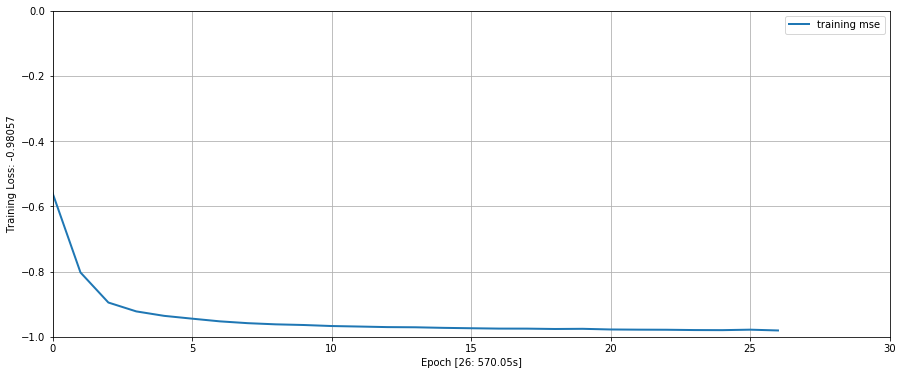

In [ ]:
if __name__ == '__main__':
    run_train()
    

# Teste nas Images

In [6]:
def run_predict(path, name, dstDir):

    print('  Loading saved weights...')

    model = get_unet()
    model.load_weights(model_name + '.model')

    print('  Load. and prepro. test data...')
       
    print('  Predicting masks on test data...')
    
    with np.load(path) as data:
        imgs_test = data['imgs_test']
    
    np.save(os.path.join(dstDir, name +'-pred.npy'), model.predict(imgs_test, verbose=0))

In [7]:
if __name__ == '__main__':
    
    start_time = time.time()
    
    print('-'*30)
    print('Test predictions...')
    print('-'*30)
    test_imgs_names = np.sort(glob.glob(os.path.join(out,test_prep_data+'/*')))
    dstDir = os.path.join(out,pred_data)
    create_new_dir(dstDir)

    for img in test_imgs_names:
        name = img.split('/')[-1].split('-')[0]
        print ("Image:", name)
        run_predict(img,name,dstDir)


    print('-'*30)
    print('Reconstructing test predictions...')
    print('-'*30)
    pred_data =  np.asarray(glob.glob(os.path.join(out,pred_data+'/*')))
    dstDir = os.path.join(out,pred_image)
    create_new_dir(dstDir)
    
    for data in pred_data:
        reconstruct_2d_sample(dstDir, data, os.path.join(out,test_mid_samples))
    
    print("--- %s seconds ---" % (time.time() - start_time))

------------------------------
Test predictions...
------------------------------
('Image:', 'CVCD10010001')
  Loading saved weights...
  Load. and prepro. test data...
  Predicting masks on test data...
('Image:', 'CVCD10010002')
  Loading saved weights...
  Load. and prepro. test data...
  Predicting masks on test data...
('Image:', 'CVCD10010003')
  Loading saved weights...
  Load. and prepro. test data...
  Predicting masks on test data...
('Image:', 'CVCD10010004')
  Loading saved weights...
  Load. and prepro. test data...
  Predicting masks on test data...
------------------------------
Reconstructing test predictions...
------------------------------
--- 1205.03274322 seconds ---


# Resultados

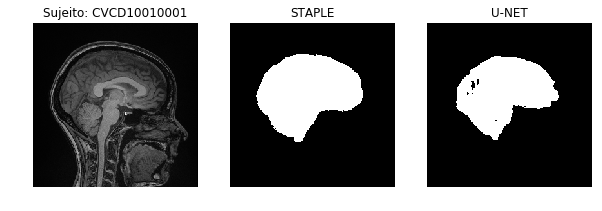

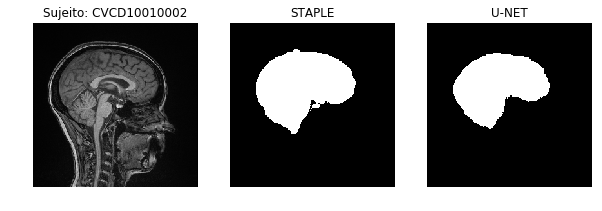

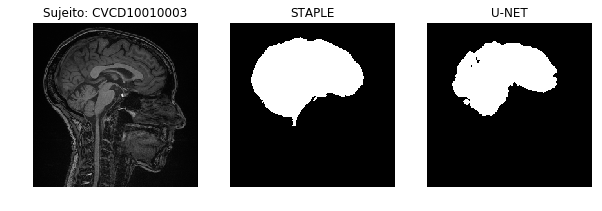

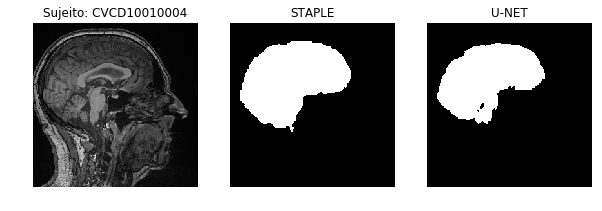

In [8]:
def plot_examples(test_image, mask_image, pred_image, name):
    
    plt.figure(figsize=(10, 15))
    plt.subplot(131)
    plt.imshow(test_image,cmap='gray')
    plt.title('Sujeito: ' + name)
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(mask_image,cmap='gray')
    plt.title('STAPLE')
    plt.axis('off')

    
    plt.subplot(133)
    plt.imshow(pred_image,cmap='gray')
    plt.title('U-NET')
    plt.axis('off')
    plt.show

if __name__ == '__main__':
    
    pred_imgs_names = np.sort(glob.glob(os.path.join(out,pred_image+'/*')))

    for img_name in pred_imgs_names:
        
        name = img_name.split('/')[-1].split('-')[0]
        test_image = cv2.imread(os.path.join(out,test_mid_samples+'/' + name +'.tif')
                                , cv2.IMREAD_GRAYSCALE)
        mask_image = cv2.imread(os.path.join(out,test_mid_samples+'/' + name +'_staple.tif')
                                , cv2.IMREAD_GRAYSCALE)
        pred_image = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
        plot_examples(test_image.T[::-1], mask_image.T[::-1], pred_image.T[::-1], name)